# Using clustering to aid separate single surname vs. multi-surname fullname data

It is quite a common scenario in software engineering to get a hold of databases where there was no separation of `first_name` and `last_name` data.

Such is the case of the dataset that I'll be working on, which contains wealth statements by civil service members.
The problem poses a common scenario for text preprocessing, and I'll be using TfIDF and KMeans to detect groups that can be used to separate first name and last name data, such as "no middle-name", "double surname", etc.


## Install necessary modules

In [1]:
!pip install pandas scikit-learn matplotlib seaborn

## Import dependencies

We'll import modules to calculate term frequency, and preprocessing modules to scale and normalize our features.

In [2]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.base import clone
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Let's load our dataset

In [3]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/nmercado1986/jupyter-notebooks/master/ddjj.csv')

## Previewing fullname data

This is the only data we will be working on, and creating our features from.

**Notice that names are in the form "last name + first name"**

In [4]:
print(df['funcionario_apellido_nombre'].sample(10))

50978                    SOTO MODESTO
32523         MARCHETTI SILVIO DANIEL
19722                 FERRARIS ANDRES
18702          FARABELLO SERGIO PABLO
54487       VELAZQUEZ GUILLERMO ANGEL
485             ADARO ROBERTO EDUARDO
46828             ROSSI SERGIO DANIEL
3979        AYERDI DIEGO MAYRA NICOLE
43429         RACIOPPE EDUARDO JAVIER
40984    PEREZ BRUSSA CAMILA VICTORIA
Name: funcionario_apellido_nombre, dtype: object


## Removing stopwords:

I found that overall we can do without stopwords. If we can derive, for example, that token 1 of the name is the surname, we can then split the name in the position right after.
Example stopwords to remove:
- de
- d'
- del
- de la
- y
- los

Also, let's ensure that tokens are all lowercase.


In [5]:
df = df[df.tipo_declaracion_jurada_id==1]

import re
df['funcionario_apellido_nombre'] = df['funcionario_apellido_nombre'].apply(lambda s: s.lower())
df['funcionario_apellido_nombre'] = df['funcionario_apellido_nombre'].apply(lambda s: re.sub(r'\b(d|d\'|\'|de|del|y|la|las|los)\b\s*', '', s))



## Split tokens from each lastname. Extract count.

Avoid dealing with type issues due to `None` 3rd token by replacing it with `--SIN NOMBRE--`

In [6]:
dftrain = pd.DataFrame()
dftrain['funcionario_apellido_nombre'] = df['funcionario_apellido_nombre']
dftrain['palabra0'] = df['funcionario_apellido_nombre'].apply(lambda s: s.split(' ')[0])
dftrain['palabra1'] = df['funcionario_apellido_nombre'].apply(lambda s: s.split(' ')[1])
dftrain['palabra2'] = df['funcionario_apellido_nombre'].apply(lambda s: s.split(' ')[2] if len(s.split(' ')) > 2 else "--SIN NOMBRE--")
dftrain['count'] = df['funcionario_apellido_nombre'].apply(lambda s: len(s.split(' ')))

###  Build a vocaculary which we will use to extract term frequency from


We will use this vocaculary as a parameter for TfIdfVectorizer

In [7]:
todosLosNombres = pd.concat([dftrain['palabra0'], dftrain['palabra1'], dftrain['palabra2']], ignore_index=True).dropna().unique()
todosLosNombres = list(map(lambda s: s.lower(), todosLosNombres))

## Extracting TfIdf and normalizing features

We will use term-frequency of the 1st, 2nd and 3rd tokens in each of the token positions. That is:

- How often does the word "Gomez" appear in the first position?
- How often does the word "Alejandro" appear in the last position?

**More importantly, we are interested in how often the 2nd token appears in position 1 and 2, vs position 0**
(Positions are 0-indexed). If the 2nd token appears more frequently in position 0 than in position 2, that means that we might be dealing with a double-surname example.

Then extract some cross features to compare frequency in first vs last position, etc.

In [8]:
pipe = Pipeline([
    ('count', CountVectorizer(vocabulary=list(todosLosNombres))),
    ('idf', TfidfTransformer(norm=None, 
                             sublinear_tf=True, 
                             smooth_idf=True))
    #('scaler', MaxAbsScaler())
])

pipe0 = clone(pipe)
pipe1 = clone(pipe)
pipe2 = clone(pipe)
pipe.fit(dftrain['funcionario_apellido_nombre'])
pipe0.fit(dftrain['palabra0'])
pipe1.fit(dftrain['palabra1'])
pipe2.fit(dftrain['palabra2'])

qtt = QuantileTransformer(n_quantiles=6)

dftrain['tf_idf_palabra1_total'] = qtt.fit_transform(
    np.amax(pipe.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1))

dftrain['tf_idf_palabra1_cross_0_total'] = qtt.fit_transform(
    np.amax(pipe0.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1) /
    np.amax(pipe.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1))

dftrain['tf_idf_palabra1_cross_1_total'] = qtt.fit_transform(
    np.amax(pipe1.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1) /
    np.amax(pipe.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1))

dftrain['tf_idf_palabra1_cross_2_total'] = qtt.fit_transform(
    np.amax(pipe2.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1) /
    np.amax(pipe.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1))


#dftrain['tf_idf_solo_dos'] = StandardScaler().fit_transform((dftrain['palabra2'] == "--SIN NOMBRE--").to_numpy().reshape(-1, 1))

# Algunos features que no vamos a extraer
#dftrain['tf_idf_palabra1'] = RobustScaler().fit_transform(np.amax(pipe.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1))
#dftrain['tf_idf_palabra0_in1'] = StandardScaler().fit_transform(np.amax(pipe1.transform(dftrain['palabra0']).toarray(), axis=1).reshape(-1, 1))
#dftrain['tf_idf_palabra0_in2'] = (np.amax(pipe2.transform(dftrain['palabra0']).toarray(), axis=1))

#dftrain['tf_idf_palabra1_comb_1_1'] = StandardScaler().fit_transform((dftrain['tf_idf_palabra1_in0'] / dftrain['tf_idf_palabra1_in2']).to_numpy().reshape(-1, 1))

#dftrain['tf_idf_palabra1_in1'] = RobustScaler().fit_transform(np.amax(pipe1.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1))

#dftrain['tf_idf_palabra2_in0'] = StandardScaler().fit_transform(np.amax(pipe0.transform(dftrain['palabra2']).toarray(), axis=1).reshape(-1, 1))
#dftrain['tf_idf_palabra2_in1'] = StandardScaler().fit_transform(np.amax(pipe1.transform(dftrain['palabra2']).toarray(), axis=1).reshape(-1, 1))
#dftrain['tf_idf_palabra2_in2'] = StandardScaler().fit_transform(np.amax(pipe2.transform(dftrain['palabra2']).toarray(), axis=1).reshape(-1, 1))
dftrain['tf_count'] = StandardScaler().fit_transform(dftrain['count'].to_numpy().reshape(-1, 1))

#print((100 * dftrain['tf_idf_palabra1_in0'] / dftrain['tf_idf_palabra1_in2']).to_numpy().reshape(-1, 1))

dftrain['tf_idf_palabra1_cross_0_1'] = qtt.fit_transform(
    np.amax(pipe0.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1) /
    np.amax(pipe1.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1))

dftrain['tf_idf_palabra1_cross_1_2'] = qtt.fit_transform(
    np.amax(pipe1.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1) /
    np.amax(pipe2.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1))

dftrain['tf_idf_palabra1_cross_0_2'] = qtt.fit_transform(
    np.amax(pipe0.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1) /
    np.amax(pipe2.transform(dftrain['palabra1']).toarray(), axis=1).reshape(-1, 1))

# Remove NAs
dftrain = dftrain[~dftrain.tf_idf_palabra1_cross_0_total.isna()]
dftrain = dftrain[~dftrain.tf_idf_palabra1_cross_1_total.isna()]
dftrain = dftrain[~dftrain.tf_idf_palabra1_cross_2_total.isna()]
dftrain = dftrain[~dftrain.tf_idf_palabra1_cross_0_1.isna()]
dftrain = dftrain[~dftrain.tf_idf_palabra1_cross_0_2.isna()]
dftrain = dftrain[~dftrain.tf_idf_palabra1_cross_1_2.isna()]

# Normalize
dftrain[dftrain.filter(regex='^tf_.*').columns] = Normalizer().fit_transform(dftrain.filter(regex='^tf_.*'))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


## Let's take a look at features for people with the surname 'gomez' somewhere in their fullname.

Let's try to make sense of features.
Take the example of "Corzo Gomez Clara".
Remember that we are working with inverse document frequency. 

So we can see Gomez (position 1) is a pretty common "first word". (`tf_idf_palabra1_cross_0_total` is near to zero).
We can also see that this same word is not a common "third word". (`tf_idf_palabra1_cross_2_total` is close to one).




In [9]:
dftrain[dftrain.funcionario_apellido_nombre.str.contains('gomez')].head(50)

,funcionario_apellido_nombre,palabra0,palabra1,palabra2,count,tf_idf_palabra1_total,tf_idf_palabra1_cross_0_total,tf_idf_palabra1_cross_1_total,tf_idf_palabra1_cross_2_total,tf_count,tf_idf_palabra1_cross_0_1,tf_idf_palabra1_cross_1_2,tf_idf_palabra1_cross_0_2
13848,corzo gomez clara isabel,corzo,gomez,clara,4,0.209285,0.001492,0.333971,0.353461,0.767261,0.062544,0.326334,0.143634
14140,criante gomez yesica ivonne,criante,gomez,yesica,4,0.209285,0.001492,0.333971,0.353461,0.767261,0.062544,0.326334,0.143634
16593,diaz gomez arturo leon,diaz,gomez,arturo,4,0.209285,0.001492,0.333971,0.353461,0.767261,0.062544,0.326334,0.143634
18765,farias gomez matias federico,farias,gomez,matias,4,0.209285,0.001492,0.333971,0.353461,0.767261,0.062544,0.326334,0.143634
19255,fernandez gomez rodrigo daniel,fernandez,gomez,rodrigo,4,0.209285,0.001492,0.333971,0.353461,0.767261,0.062544,0.326334,0.143634
21621,gallardo gomez felix gaston,gallardo,gomez,felix,4,0.209285,0.001492,0.333971,0.353461,0.767261,0.062544,0.326334,0.143634
22204,garcia gomez gonzalo antonio,garcia,gomez,gonzalo,4,0.209285,0.001492,0.333971,0.353461,0.767261,0.062544,0.326334,0.143634
23251,gil gomez maria eugenia,gil,gomez,maria,4,0.209285,0.001492,0.333971,0.353461,0.767261,0.062544,0.326334,0.143634
23898,gomez adrian nestor,gomez,adrian,nestor,3,0.326206,0.433324,0.556541,0.127483,-0.035300,0.438574,0.310870,0.299327
23899,gomez aguirre mauricio maximiliano,gomez,aguirre,mauricio,4,0.272298,0.001000,0.307922,0.307650,0.735976,0.183712,0.329722,0.228604


# Clustering using KMeans

I found KMeans to work best as:

- I'm not interested in detecting outliers
- In my tests, I saw DBSCAN needed a very small epsilon to provide meaningful clusters. Then I ended up with hundreds of clusters, too many to go through.

Now let's try different values for `n_clusters` and get the one with the best silhouette score.

In [10]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score
import math

pgrid = ParameterGrid({ 
    'n_clusters' : [ 2, 3, 5, 10, 15, 25, 35],
    })

features = Normalizer().fit_transform(dftrain.filter(regex='tf_.*'))

best = None
bestScore = -np.Inf
for params in pgrid:

  dbs = KMeans(**params, random_state=0)
  dbs.fit(features)


  try:
    score = math.floor(100.0 * silhouette_score(features, dbs.labels_)) / 100
    print(params, score)
    if score >= bestScore:
      best = dbs
      bestScore = score
  except Exception as e:
    print(e)
    continue
  
dftrain['cluster'] = best.fit_predict(dftrain.filter(regex='tf_.*'))

print(best)

{'n_clusters': 2} 0.29
{'n_clusters': 3} 0.37
{'n_clusters': 5} 0.45
{'n_clusters': 10} 0.43
{'n_clusters': 15} 0.43
{'n_clusters': 25} 0.48
{'n_clusters': 35} 0.5
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=35, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)


## Taking a look at formed clusters

Let's take a look at cluster sizes in general

In [11]:
print(dftrain['cluster'].value_counts())
print(dftrain['cluster'].max())

11    2440
4     2392
15    2293
17    2135
6     2025
26    1875
22    1811
21    1744
30    1704
5     1680
16    1469
1     1439
8     1420
25    1406
32    1247
27    1244
19    1145
14    1077
31    1074
0     1040
13    1032
18    1017
7      964
23     930
2      842
10     831
20     816
34     812
12     737
24     725
28     698
9      612
33     573
29     489
3      465
Name: cluster, dtype: int64
34


Let's use T-SNE to plot our feature space. We will use a small sample as it seems T-SNE takes a very long time with more than a few thousand samples.

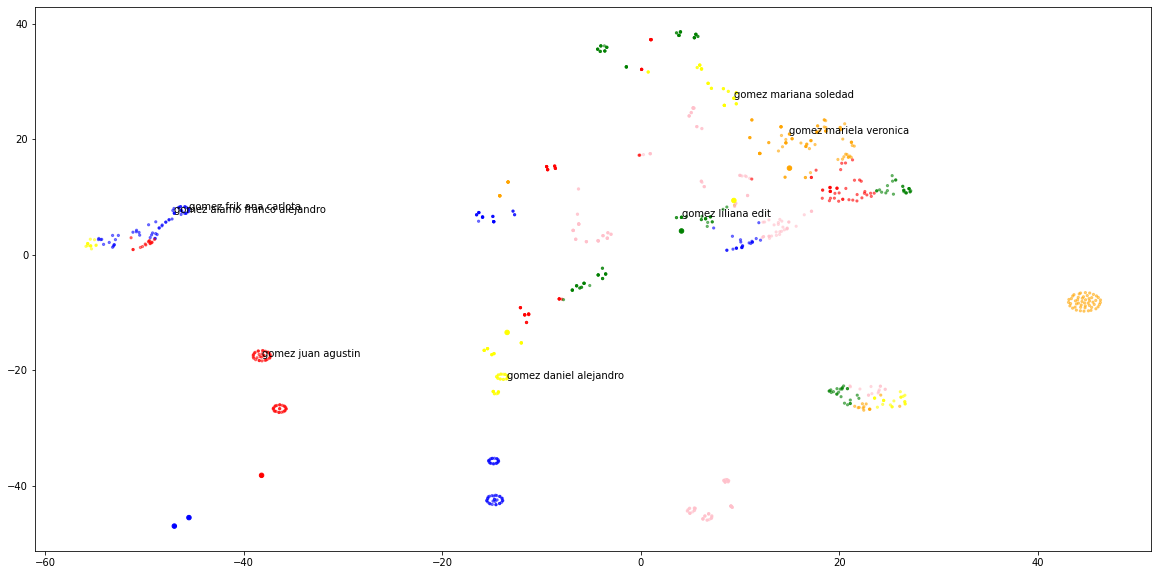

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

plt.rcParams['figure.figsize'] = [20, 10]


fig = plt.figure()

def plotApellidos(dftrain, apellido, ax):
    """ Plotea los nombres de un apellido vs la totalidad del dataset en 2d
    """
    dfsample = dftrain.sample(1000)
    colors = ['red', 'green', 'blue', 'yellow', 'pink', 'orange']
        
    """ TSNE tarda mucho con muestras grandes """
    tsne = TSNE(n_iter=1000)
    proj = tsne.fit_transform(dfsample.filter(regex = 'tf_.*'))
    dfsample['tsne0'] = proj[:,0]
    dfsample['tsne1'] = proj[:,1]

    dfApellido = dfsample[dfsample.funcionario_apellido_nombre.str.contains(apellido)]


    
    #projApellido = tsne.fit_transform(dfApellido.filter(regex = 'tf_.*'))
    #dfApellido['pca0'] = projApellido[:,0]
    #dfApellido['pca1'] = projApellido[:,1]
    
    ax.scatter(dfsample['tsne0'], dfsample['tsne1'], alpha=.5, s=5, c= dfsample['cluster'].apply(lambda i: colors[ i % len(colors) ]))
    ax.scatter(dfApellido['tsne0'], dfApellido['tsne0'], s=20, c= dfApellido['cluster'].apply(lambda i: colors[ i % len(colors) ]))

    for id, row in dfApellido.iterrows():
        ax.annotate(row['funcionario_apellido_nombre'], (row['tsne0'], row['tsne1']))


    plt.show()
    
    
 

plotApellidos(dftrain, 'gomez', fig.add_subplot('111'))

## How was each of the Gomez classified?

We can see many different values for clusters.
The number of clusters is manageable (it's not so tedious to identify which out of the 35 clusters belong to double-surname people).
The results are overall very good, although we can spot some samples that shouldn't have been grouped together.
For example: `Gomez Benigno Alejandro Eugenio` is a single-surname case and should not have been grouped with `Gomez Beret Federico Nicolas`, as `Beret` is clearly a second lastname.


In [13]:
dfgomez = dftrain[dftrain.funcionario_apellido_nombre.str.contains('gomez')]
dfgomez[['funcionario_apellido_nombre', 'cluster']].head(50)

,funcionario_apellido_nombre,cluster
13848,corzo gomez clara isabel,18
14140,criante gomez yesica ivonne,18
16593,diaz gomez arturo leon,18
18765,farias gomez matias federico,18
19255,fernandez gomez rodrigo daniel,18
21621,gallardo gomez felix gaston,18
22204,garcia gomez gonzalo antonio,18
23251,gil gomez maria eugenia,18
23898,gomez adrian nestor,25
23899,gomez aguirre mauricio maximiliano,18


### Other surnames

Let's take a look at a less common surname: Avecedo.

In [14]:

dfacevedo = dftrain[dftrain.funcionario_apellido_nombre.str.contains('acevedo')]
dfacevedo[['funcionario_apellido_nombre', 'cluster']]

,funcionario_apellido_nombre,cluster
219,acevedo alberto enrique,15
223,acevedo arnaldo daniel,30
224,acevedo barbara yanel,5
225,acevedo carlos adrian,26
226,acevedo cesar alberto,14
227,acevedo daniel alberto jesus,9
228,acevedo delia beatriz,30
230,acevedo diaz eduardo alejandro,18
231,acevedo eduardo horacio,15
232,acevedo gabriel esteban,0


In [15]:
grupos = dftrain.groupby('cluster').apply(lambda x: x.sample(3))
with pd.option_context('display.max_rows', None):
  print(grupos)

                        funcionario_apellido_nombre  ... cluster
cluster                                              ...        
0       10332                   cardozo oscar ramon  ...       0
        30663                  lopez javier gonzalo  ...       0
        52847                  torres oscar alberto  ...       0
1       35967             montivero carolina lorena  ...       1
        43829               randazzo rodolfo alvaro  ...       1
        818                 aguirre liliana beatriz  ...       1
2       41254           perez paladino pablo adrian  ...       2
        10636            carrio elisa maria avelina  ...       2
        24383        gonzalez aleman rafael enrique  ...       2
3       48881                      saravia federico  ...       3
        54576                      venanzi santiago  ...       3
        55231                        vilela nicolas  ...       3
4       45792             rodriguez pablo adalberto  ...       4
        38484            

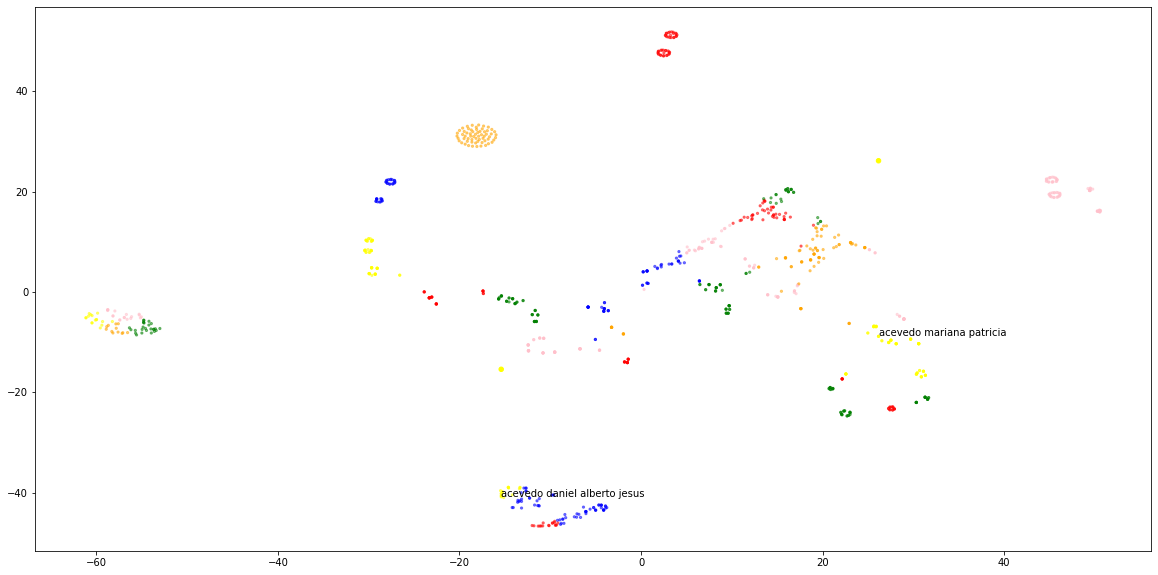

In [16]:
plotApellidos(dftrain, 'acevedo', plt.figure().add_subplot('111'))

In [17]:
dfpereyra = dftrain[dftrain.funcionario_apellido_nombre.str.contains('pereyra')].head(50)
dfpereyra[['funcionario_apellido_nombre', 'cluster']]

,funcionario_apellido_nombre,cluster
18782,farias pereyra nestor emiliano,18
19508,fernandez pereyra miguel aquiles,18
40850,pereyra agustin andr,8
40851,pereyra alejandro fabio,15
40852,pereyra ana laura,21
40853,pereyra ana teresa,21
40854,pereyra ariel,23
40855,pereyra ariel manuel,25
40857,pereyra armando horacio,16
40858,pereyra atilio ruben,16


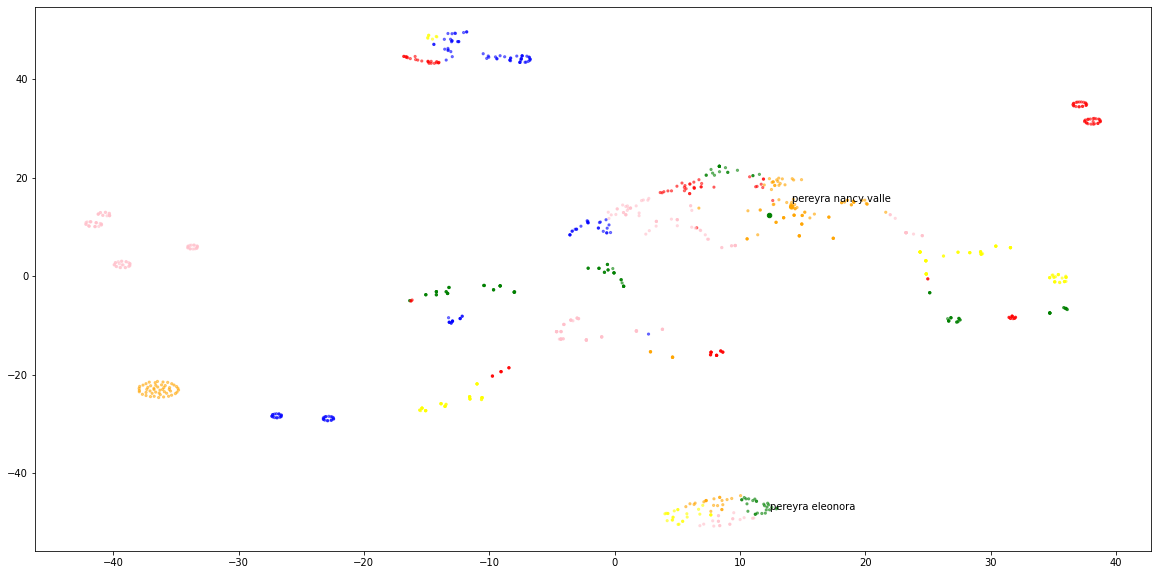

In [18]:
plotApellidos(dftrain, 'pereyra', plt.figure().add_subplot('111'))

## Now export clusters into separate CSV files

In [19]:
dftrain[dftrain.cluster.isin([3,  5,  6, 17, 25, 26, 33, 34])].to_csv('2_or_more.csv')
dftrain[~dftrain.cluster.isin([3,  5,  6, 17, 25, 26, 33, 34])].to_csv('1_surname.csv')

The clusters for people with 1 surname are under [1_surname.csv](./content/1_surname.csv) and the rest under [2_or_more.csv](./content/2_or_more.csv).